# BTC Prediction (Modeling Stage)

### This notebook contains:

The goal of this notebook is to successfully predict BTCs next day close price using various models or methods. The X variable is the features used to predict the price, and the y variable is our target prediction. The target prediction is simply the next days close price shifted to fit each row. 

#### Models Used:

- Linear regression (LR)
    - Ordinary Least Squares (OLS)
    - Lasso
    - Ridge
- Random forest regression (RFR)
- Time series forecasting with long short term memory (LSTM)

Both linear and random forest regression utilize _GridSearchCV()_ to tune hyperparameters. Using grid search through the model pipeline I added an additional tuner as _PolynomialFeatures()_. From my own research the addition of polynomial features usually improves linear regression models significantly. 

As for the time series forecasting using LSTM, I utilize a "Keras" wrapper called "hyperas" in order to tune the LSTM models hyperparameters (i.e. Dropout, Activation, Dense, Optimizer, Batch Size and Epochs). 

After running the models you will see two graphical representations as subplots(scatter and line plot) demonstrating their performance. Providing a visual that shows the actual close price compared to the predicted price. 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, preprocessing
from sklearn.metrics import accuracy_score
from sklearn import metrics

import statsmodels.api as sm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('data/train.csv', index_col='Date')

In [3]:
dataset.head()

,close,volume,ema_short,ema_long,atr,obv,tweet_sentiment,close_nextday
Date,,,,,,,,
2019-09-02,10340.00,44740.25,10164.518939,10452.265343,530.693553,225053.863244,-1.0,10615.28
2019-09-03,10615.28,47998.38,10207.448563,10458.658074,528.572585,273052.240025,0.5,10567.02
2019-09-04,10567.02,43943.89,10241.693462,10462.907561,521.468114,229108.350999,0.5,10564.49
2019-09-05,10564.49,33970.96,10272.435990,10466.891187,516.363249,195137.390360,0.5,10298.73
2019-09-06,10298.73,58799.64,10274.940181,10460.296630,533.470874,136337.749401,0.0,10455.88


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, 2019-09-02 to 2020-11-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   close            441 non-null    float64
 1   volume           441 non-null    float64
 2   ema_short        441 non-null    float64
 3   ema_long         441 non-null    float64
 4   atr              441 non-null    float64
 5   obv              441 non-null    float64
 6   tweet_sentiment  441 non-null    float64
 7   close_nextday    441 non-null    float64
dtypes: float64(8)
memory usage: 31.0+ KB


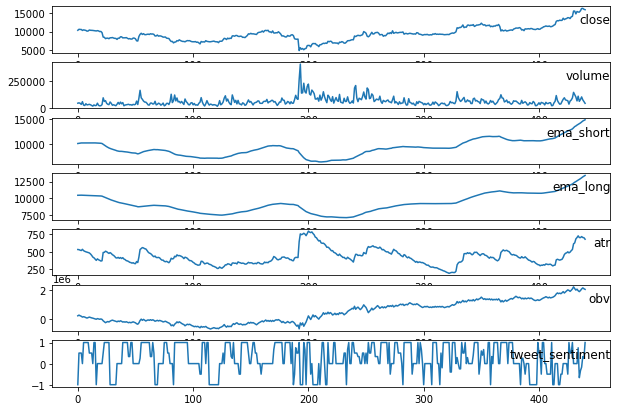

In [5]:
import matplotlib.pyplot as plt

values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(10, 7))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# Modeling

We split the original dataset using _TimeSeriesSplit()_, making our X every feature except "close_nextday". The target is "close_nextday" so we use that variable as our y. The split used was a 75% train and 25% test. X_train and y_train are the first 75% of the original dataset and X_test, y_test contain the last 25% of the original dataset.

### Techniques:

##### - Ordinary Least Squares (OLS)
    
Minimizes bias of OLS function with the "Best Linear Unbiased Estimator" (BLUE).
    
\begin{equation}
\mathcal{L}_{OLS} = ||Y-X^T\beta||^2
\end{equation}
    
##### - Lasso

Different minimization function than OLS. Penalizes large beta values.
    
\begin{equation}
\mathcal{L}_{LASSO}  = ||Y - X^T\beta||^2 + \lambda ||\beta||
\end{equation}

##### - Ridge

Has a similar penalty of beta values as Lasso, but has a different "bias".
    
\begin{equation}
\mathcal{L}_{Ridge} = ||Y - X^T\beta||^2 + \lambda ||\beta||^2
\end{equation}
<br>
<br>

**Both Lasso and Ridge Regressions are considered to have _good_ bias as long as:**

\begin{equation}
\lambda > 0
\end{equation}

**They are considered to be "better" in performance compared to OLS because of this _good_ bias, although, that is not always the case.** 
<br>
##### - Random Forest Regressor (RFR)

A supervised learning ensemble method that uses a bagging technique where its trees run parallel and do not interact. As a "meta-estimator" it combines multiple predictions (trees), and produces outputs from the best performance of those aggregate estimations.

### Tuning Hyperparameters:

##### - Pipeline
- PolynomialFeatures()
- OLS, Lasso, Ridge



##### - GridSearchCV Params:
- Lasso, Ridge: "fit_alpha"
- RFR: "n_estimators", "max_depth", "max_features", "bootstrap"

## Test 1 

In [6]:
# Subset dataset into X, y. X is features, y is target

X = dataset.drop(labels=['close_nextday'], axis=1)
y = dataset['close_nextday']

print(X.head())

               close    volume     ema_short      ema_long         atr  \
Date                                                                     
2019-09-02  10340.00  44740.25  10164.518939  10452.265343  530.693553   
2019-09-03  10615.28  47998.38  10207.448563  10458.658074  528.572585   
2019-09-04  10567.02  43943.89  10241.693462  10462.907561  521.468114   
2019-09-05  10564.49  33970.96  10272.435990  10466.891187  516.363249   
2019-09-06  10298.73  58799.64  10274.940181  10460.296630  533.470874   

                      obv  tweet_sentiment  
Date                                        
2019-09-02  225053.863244             -1.0  
2019-09-03  273052.240025              0.5  
2019-09-04  229108.350999              0.5  
2019-09-05  195137.390360              0.5  
2019-09-06  136337.749401              0.0  


In [7]:
# Split X, y using TimeSeriesSplit() into X_train, X_test, y_train, y_test. First 75% is training, 25% is test

tss = TimeSeriesSplit(n_splits=3)  # n_splits = 3-1...2 splits

for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [8]:
# Check train, test splits for correct date alignment and matching shape

print("X_train:\n", X_train, X_train.shape, "\n", '\nX_test:\n', X_test,
      X_test.shape)
print("\n")
print("y_train:\n", y_train, y_train.shape, "\n", '\ny_test:\n', y_test,
      y_test.shape)

X_train:
                close     volume     ema_short      ema_long         atr  \
Date                                                                      
2019-09-02  10340.00   44740.25  10164.518939  10452.265343  530.693553   
2019-09-03  10615.28   47998.38  10207.448563  10458.658074  528.572585   
2019-09-04  10567.02   43943.89  10241.693462  10462.907561  521.468114   
2019-09-05  10564.49   33970.96  10272.435990  10466.891187  516.363249   
2019-09-06  10298.73   58799.64  10274.940181  10460.296630  533.470874   
...              ...        ...           ...           ...         ...   
2020-07-24   9537.80   43931.14   9319.820787   9252.782403  206.397467   
2020-07-25   9700.42   40679.55   9356.068331   9270.336819  207.361933   
2020-07-26   9931.54   65279.27   9410.875156   9296.266355  225.478938   
2020-07-27  11029.96  150188.93   9565.073713   9364.254341  314.919728   
2020-07-28  10906.27   97267.73   9692.806693   9424.725543  340.799033   

              

In [9]:
# Reshape y train, test to match X train, test

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [10]:
# Scale X_train, X_test, y_train, y_test to prevent overfitting and minimize outliers like large values

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)
y_train = ss.fit_transform(y_train)
y_test = ss.fit_transform(y_test)

In [11]:
# Make sure shape is same before scaling. 

print("X Train:", type(X_train), X_train.shape, len(X_train))
print("\nX Test:", type(X_test), X_test.shape, len(X_test))
print("\ny Train:", type(y_train), y_train.shape, len(y_train))
print("\ny Test:", type(y_test), y_test.shape, len(y_test))

X Train: <class 'numpy.ndarray'> (331, 7) 331

X Test: <class 'numpy.ndarray'> (110, 7) 110

y Train: <class 'numpy.ndarray'> (331, 1) 331

y Test: <class 'numpy.ndarray'> (110, 1) 110


In [12]:
# Test function to run prediction error metrics from model pipline 

def test(models, iterations=100):
    results = {}
    for i in models:
        r2_test = []
        r2_train = []
        MAE_test = []
        MAE_train = []
        MSE_test = []
        MSE_train = []
        MAPE_test = []
        MAPE_train = []
        for j in range(iterations):
            r2_test.append(
                metrics.r2_score(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            r2_train.append(
                metrics.r2_score(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MAE_test.append(
                metrics.mean_absolute_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MAE_train.append(
                metrics.mean_absolute_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MSE_test.append(
                metrics.mean_squared_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MSE_train.append(
                metrics.mean_squared_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))
            MAPE_test.append(
                metrics.mean_absolute_percentage_error(
                    y_test, models[i].fit(X_train, y_train).predict(X_test)))
            MAPE_train.append(
                metrics.mean_absolute_percentage_error(
                    y_train, models[i].fit(X_train, y_train).predict(X_train)))

        results[i] = [
            np.mean(r2_train),
            np.mean(r2_test),
            np.mean(MAE_train),
            np.mean(MAE_test),
            np.mean(MSE_train),
            np.mean(MSE_test),
            np.mean(MAPE_train),
            np.mean(MAPE_test)
        ]

    return pd.DataFrame(results)

In [13]:
# Build GridSearchCV params for models with pipeline

lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}
rfr_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth': range(20, 30),
    #'min_samples_split': range(1, 10),
    #'min_samples_leaf': range(1, 5),
    "max_features": ["auto"],
    "bootstrap": [True, False]
}

pipe1 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.LinearRegression())])
pipe2 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Lasso())])
pipe3 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Ridge())])

models = {
    'OLS':
    pipe1,
    'Lasso':
    GridSearchCV(pipe2, param_grid=lasso_params).fit(
        X_train, y_train).best_estimator_,
    'Ridge':
    GridSearchCV(pipe3, param_grid=ridge_params).fit(
        X_train, y_train).best_estimator_,
    'RFR':
    GridSearchCV(RandomForestRegressor(), param_grid=rfr_params).fit(
        X_train, y_train).best_estimator_,
}

In [14]:
# Create model test variables for visual performance evaluation

pred_ols = models['OLS'].fit(X_train, y_train).predict(X_test)
pred_lasso = models['Lasso'].fit(X_train, y_train).predict(X_test)
pred_ridge = models['Ridge'].fit(X_train, y_train).predict(X_test)
pred_rfr = models['RFR'].fit(X_train, y_train).predict(X_test)

In [15]:
# Model performance comparision between train and test

scores = test(models['OLS', 'Lasso', 'Ridge'])
scores = scores.T
scores.columns = [
    'R^2 Test', 'R^2 Train', 'MAE Test', 'MAE Train', 'MSE Test', 'MSE Train',
    'MAPE Test', 'MAPE Train'
]
scores['RMSE Train'] = scores['MSE Train']**2
scores['RMSE Test'] = scores['MSE Test']**2

print(scores)

       R^2 Test  R^2 Train  MAE Test  MAE Train  MSE Test  MSE Train  \
OLS    0.938214   0.942125  0.159420   0.170665  0.061786   0.057875   
Lasso  0.930383   0.959676  0.164646   0.133347  0.069617   0.040324   
Ridge  0.753846   0.716989  0.400992   0.419430  0.246154   0.283011   
RFR    0.988466   0.918239  0.067798   0.201983  0.011566   0.081874   

       MAPE Test  MAPE Train  RMSE Train  RMSE Test  
OLS     0.551649    0.779916    0.003349   0.003817  
Lasso   0.791528    0.612999    0.001626   0.004847  
Ridge   1.512188    0.800115    0.080095   0.060592  
RFR     0.479888    0.937415    0.006703   0.000134  


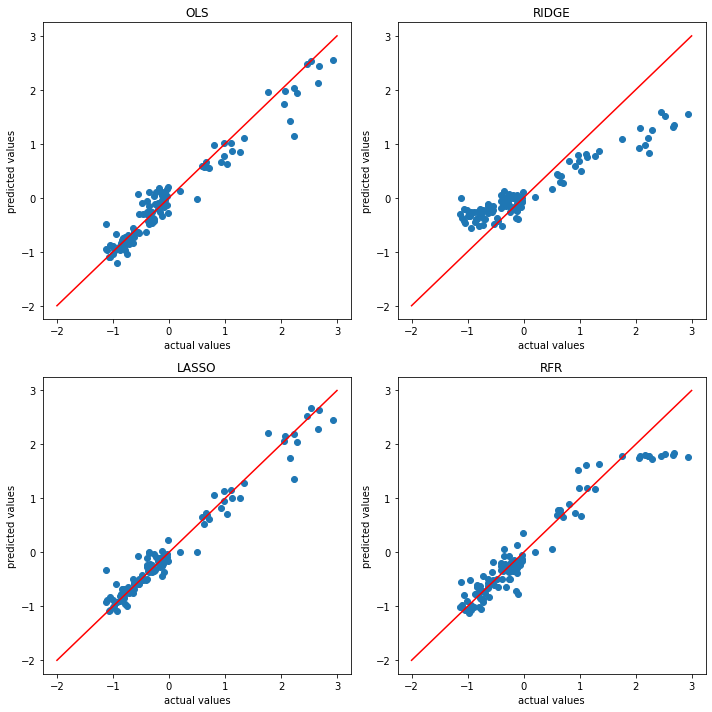

In [16]:
# Performance visual for each model, prediction vs actual subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_test, pred_ols)
axs[0, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 0].set_xlabel('actual values')
axs[0, 0].set_ylabel('predicted values')
axs[0, 0].set_title("OLS")

axs[1, 0].scatter(y_test, pred_lasso)
axs[1, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 0].set_xlabel('actual values')
axs[1, 0].set_ylabel('predicted values')
axs[1, 0].set_title("LASSO")

axs[0, 1].scatter(y_test, pred_ridge)
axs[0, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 1].set_xlabel('actual values')
axs[0, 1].set_ylabel('predicted values')
axs[0, 1].set_title("RIDGE")

axs[1, 1].scatter(y_test, pred_rfr)
axs[1, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 1].set_title("RFR")
axs[1, 1].set_xlabel('actual values')
axs[1, 1].set_ylabel('predicted values')
fig.tight_layout()

plt.show()

fig.savefig('ActualVsTest(Test1_subplot1).png')

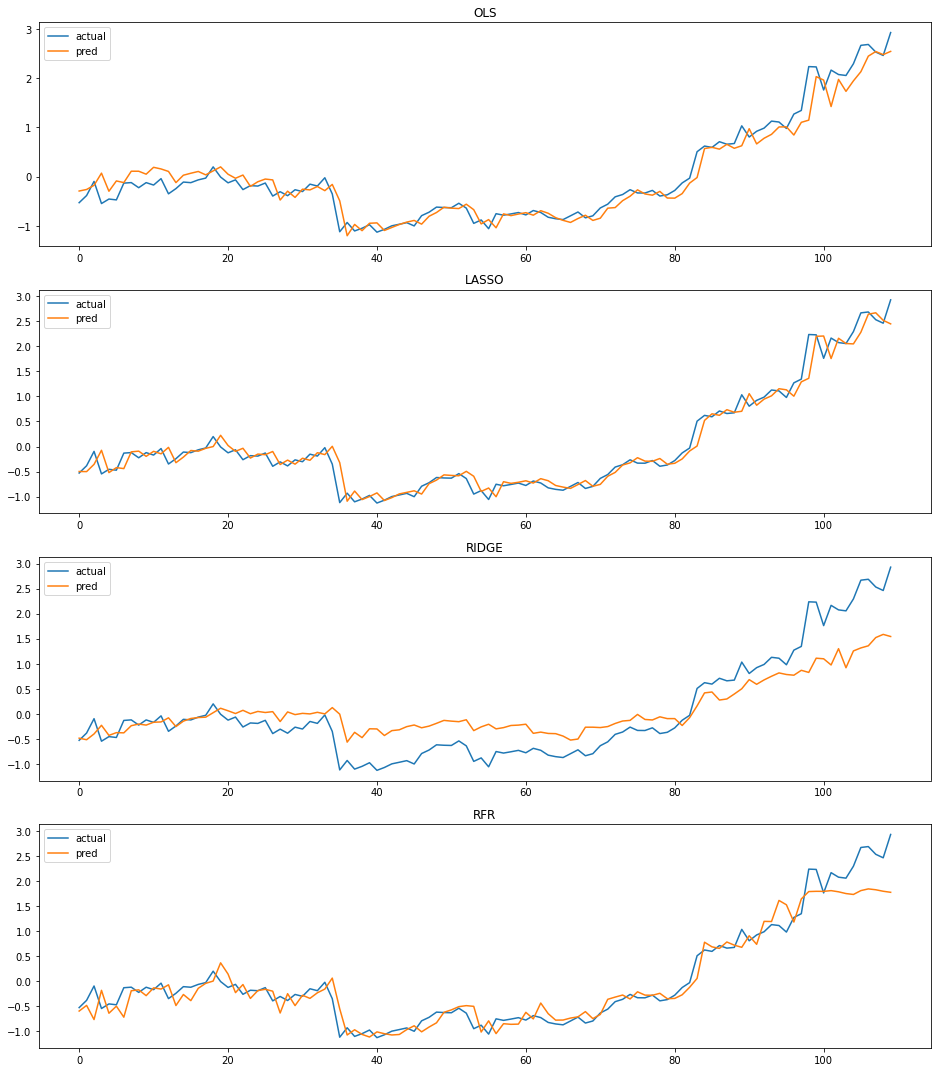

In [17]:
# Performance visual for each model, prediction vs actual subplots

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(13, 15))
ax1.plot(y_test)
ax1.plot(pred_ols)
ax1.legend(["actual", "pred"])
ax1.set_title("OLS")
ax2.plot(y_test)
ax2.plot(pred_lasso)
ax2.legend(["actual", "pred"])
ax2.set_title("LASSO")
ax3.plot(y_test)
ax3.plot(pred_ridge)
ax3.legend(["actual", "pred"])
ax3.set_title("RIDGE")
ax4.plot(y_test)
ax4.plot(pred_rfr)
ax4.legend(["actual", "pred"])
ax4.set_title("RFR")
fig.tight_layout()

plt.show()

fig.savefig('ActualVsTest(Test1_subplot2).png')

## Test 2  -  Alleviating Redundancy and Overfitting 

As our EDA showed us during the early stages of analysis, we found that the close price had a extremely high correlation with our target, "close_nextday". Because of this, we are removing the close price feature to make sure the models aren't overfit and to see if it improves or makes the models worse. 

The first cell below shows the exact correlation between "close" and "close_nextday" numerically. 

Our identified thresehold was:

- 0.7 to 0.8 = high correlation
- 0.5 to 0.6 = medium correlation
- 0 to 0.4 = low or no correlation 

The correlation between "close" and "close_nextday" was approx. 0.986686, which would be considered "to correlated" in our case.

### _**The same steps were used in "Test2" that were performed in "Test1", only difference is new X variable.**_

In [18]:
# Pull in correlation data gathered from EDA correlation heatmap

f = open('data/highest_corr_target.txt', 'r')
file_contents = f.read()
print('Highest correlated variable with target:\n', "\n", file_contents)

Highest correlated variable with target:
 
 close  close_nextday    0.986686
dtype: float64
print(c2)print('Highest Correlated Variable:', c2)print(c2)


In [19]:
X2 = dataset.drop(labels=['close_nextday', 'close'], axis=1)
y2 = dataset['close_nextday']

print(X2.head())

              volume     ema_short      ema_long         atr            obv  \
Date                                                                          
2019-09-02  44740.25  10164.518939  10452.265343  530.693553  225053.863244   
2019-09-03  47998.38  10207.448563  10458.658074  528.572585  273052.240025   
2019-09-04  43943.89  10241.693462  10462.907561  521.468114  229108.350999   
2019-09-05  33970.96  10272.435990  10466.891187  516.363249  195137.390360   
2019-09-06  58799.64  10274.940181  10460.296630  533.470874  136337.749401   

            tweet_sentiment  
Date                         
2019-09-02             -1.0  
2019-09-03              0.5  
2019-09-04              0.5  
2019-09-05              0.5  
2019-09-06              0.0  


In [20]:
tss = TimeSeriesSplit(n_splits=3)  # n_splits = 3-1...2 splits - 75% train, 25% test

for train_index, test_index in tss.split(X2):
    X2_train, X2_test = X2.iloc[train_index, :], X2.iloc[test_index, :]
    y2_train, y2_test = y2.iloc[train_index], y2.iloc[test_index]

In [21]:
print("X_train:\n", X2_train, X2_train.shape, "\n", '\nX_test:\n', X2_test,
      X2_test.shape)
print("\n")
print("y_train:\n", y2_train, y2_train.shape, "\n", '\ny_test:\n', y2_test,
      y2_test.shape)

X_train:
                volume     ema_short      ema_long         atr           obv  \
Date                                                                          
2019-09-02   44740.25  10164.518939  10452.265343  530.693553  2.250539e+05   
2019-09-03   47998.38  10207.448563  10458.658074  528.572585  2.730522e+05   
2019-09-04   43943.89  10241.693462  10462.907561  521.468114  2.291084e+05   
2019-09-05   33970.96  10272.435990  10466.891187  516.363249  1.951374e+05   
2019-09-06   58799.64  10274.940181  10460.296630  533.470874  1.363377e+05   
...               ...           ...           ...         ...           ...   
2020-07-24   43931.14   9319.820787   9252.782403  206.397467  9.441113e+05   
2020-07-25   40679.55   9356.068331   9270.336819  207.361933  9.847908e+05   
2020-07-26   65279.27   9410.875156   9296.266355  225.478938  1.050070e+06   
2020-07-27  150188.93   9565.073713   9364.254341  314.919728  1.200259e+06   
2020-07-28   97267.73   9692.806693   9424

In [22]:
# Reshape y train, test to match X train, test

y2_train = y2_train.values.reshape(-1, 1)
y2_test = y2_test.values.reshape(-1, 1)

In [23]:
ss = StandardScaler()

X2_train = ss.fit_transform(X2_train)
X2_test = ss.fit_transform(X2_test)
y2_train = ss.fit_transform(y2_train)
y2_test = ss.fit_transform(y2_test)

In [24]:
print("X Train:", type(X2_train), X2_train.shape, len(X2_train))
print("\nX Test:", type(X2_test), X2_test.shape, len(X2_test))
print("\ny Train:", type(y2_train), y2_train.shape, len(y2_train))
print("\ny Test:", type(y2_test), y2_test.shape, len(y2_test))

X Train: <class 'numpy.ndarray'> (331, 6) 331

X Test: <class 'numpy.ndarray'> (110, 6) 110

y Train: <class 'numpy.ndarray'> (331, 1) 331

y Test: <class 'numpy.ndarray'> (110, 1) 110


In [25]:
def test2(models2, iterations=100):
    results2 = {}
    for i in models2:
        r2_test2 = []
        r2_train2 = []
        MAE_test2 = []
        MAE_train2 = []
        MSE_test2 = []
        MSE_train2 = []
        MAPE_test2 = []
        MAPE_train2 = []
        for j in range(iterations):
            r2_test2.append(
                metrics.r2_score(
                    y2_test, models2[i].fit(X2_train, y2_train).predict(X2_test)))
            r2_train2.append(
                metrics.r2_score(
                    y2_train, models2[i].fit(X2_train, y2_train).predict(X2_train)))
            MAE_test2.append(
                metrics.mean_absolute_error(
                    y2_test, models2[i].fit(X2_train, y2_train).predict(X2_test)))
            MAE_train2.append(
                metrics.mean_absolute_error(
                    y2_train, models2[i].fit(X2_train, y2_train).predict(X2_train)))
            MSE_test2.append(
                metrics.mean_squared_error(
                    y2_test, models2[i].fit(X2_train, y2_train).predict(X2_test)))
            MSE_train2.append(
                metrics.mean_squared_error(
                    y2_train, models2[i].fit(X2_train, y2_train).predict(X2_train)))
            MAPE_test2.append(
                metrics.mean_absolute_percentage_error(
                    y2_test, models2[i].fit(X2_train, y2_train).predict(X2_test)))
            MAPE_train2.append(
                metrics.mean_absolute_percentage_error(
                    y2_train, models2[i].fit(X2_train, y2_train).predict(X2_train)))

        results2[i] = [
            np.mean(r2_train2),
            np.mean(r2_test2),
            np.mean(MAE_train2),
            np.mean(MAE_test2),
            np.mean(MSE_train2),
            np.mean(MSE_test2),
            np.mean(MAPE_train2),
            np.mean(MAPE_test2)
        ]

    return pd.DataFrame(results2)

In [26]:
lasso_params2 = {'fit__alpha': [0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params2 = {'fit__alpha': [550, 580, 600, 620, 650]}
rfr_params2 = {
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth': range(20, 30),
    #'min_samples_split': range(1, 10),
    #'min_samples_leaf': range(1, 5),
    "max_features": ["auto"],
    "bootstrap": [True, False]
}

pipe1_1 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.LinearRegression())])
pipe2_2 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Lasso())])
pipe3_3 = Pipeline([('poly', PolynomialFeatures()),
                  ('fit', linear_model.Ridge())])

models2 = {
    'OLS':
    pipe1_1,
    'Lasso':
    GridSearchCV(pipe2_2, param_grid=lasso_params2).fit(X2_train,
                                                     y2_train).best_estimator_,
    'Ridge':
    GridSearchCV(pipe3_3, param_grid=ridge_params2).fit(X2_train,
                                                     y2_train).best_estimator_,
    'RFR':
    GridSearchCV(RandomForestRegressor(),
                 param_grid=rfr_params2).fit(X2_train,
                                            y2_train).best_estimator_,
}

In [27]:
pred_ols2 = models2['OLS'].fit(X2_train, y2_train).predict(X2_test)
pred_lasso2 = models2['Lasso'].fit(X2_train, y2_train).predict(X2_test)
pred_ridge2 = models2['Ridge'].fit(X2_train, y2_train).predict(X2_test)
pred_rfr2 = models2['RFR'].fit(X2_train, y2_train).predict(X2_test)

In [28]:
scores2 = test2(models2)
scores2 = scores2.T
scores2.columns = [
    'R^2 Test', 'R^2 Train', 'MAE Test', 'MAE Train', 'MSE Test', 'MSE Train',
    'MAPE Test', 'MAPE Train'
]
scores2['RMSE Train'] = scores2['MSE Train']**2
scores2['RMSE Test'] = scores2['MSE Test']**2

print(scores2)

       R^2 Test  R^2 Train  MAE Test  MAE Train  MSE Test  MSE Train  \
OLS    0.873964   0.838532  0.252477   0.314968  0.126036   0.161468   
Lasso  0.787204   0.872796  0.349242   0.289085  0.212796   0.127204   
Ridge  0.626919   0.498415  0.503242   0.534351  0.373081   0.501585   
RFR    0.982139   0.799801  0.086085   0.350171  0.017944   0.199944   

       MAPE Test  MAPE Train  RMSE Train  RMSE Test  
OLS     1.676104    1.697177    0.026072   0.015885  
Lasso   2.458333    0.926742    0.016181   0.045282  
Ridge   1.761143    0.898527    0.251588   0.139189  
RFR     0.461308    1.845091    0.039978   0.000322  


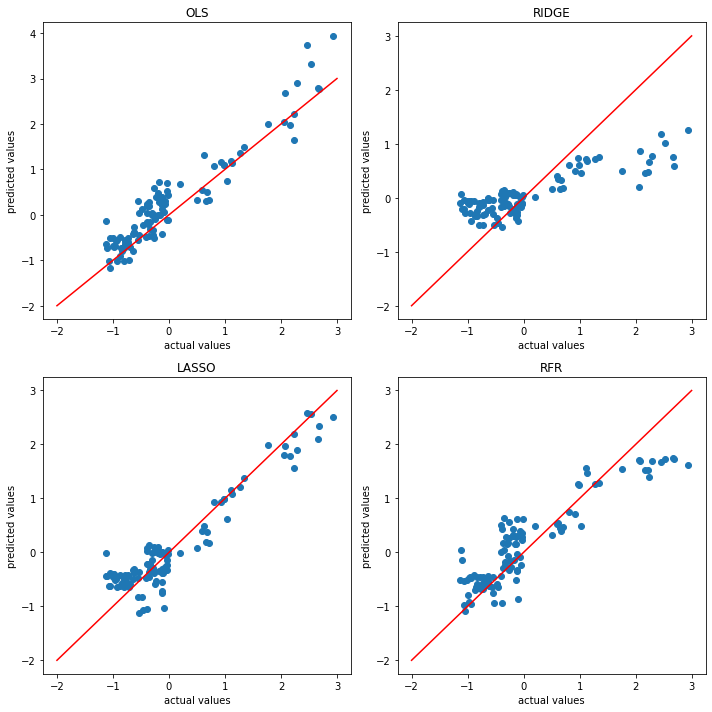

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y2_test, pred_ols2)
axs[0, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 0].set_xlabel('actual values')
axs[0, 0].set_ylabel('predicted values')
axs[0, 0].set_title("OLS")

axs[1, 0].scatter(y2_test, pred_lasso2)
axs[1, 0].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 0].set_xlabel('actual values')
axs[1, 0].set_ylabel('predicted values')
axs[1, 0].set_title("LASSO")

axs[0, 1].scatter(y2_test, pred_ridge2)
axs[0, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[0, 1].set_xlabel('actual values')
axs[0, 1].set_ylabel('predicted values')
axs[0, 1].set_title("RIDGE")

axs[1, 1].scatter(y2_test, pred_rfr2)
axs[1, 1].plot([x for x in range(-2, 4)], [y for y in range(-2, 4)],
               color='red')
axs[1, 1].set_title("RFR")
axs[1, 1].set_xlabel('actual values')
axs[1, 1].set_ylabel('predicted values')
fig.tight_layout()

plt.show()

fig.savefig('ActualVsTest(Test2_subplot1).png')

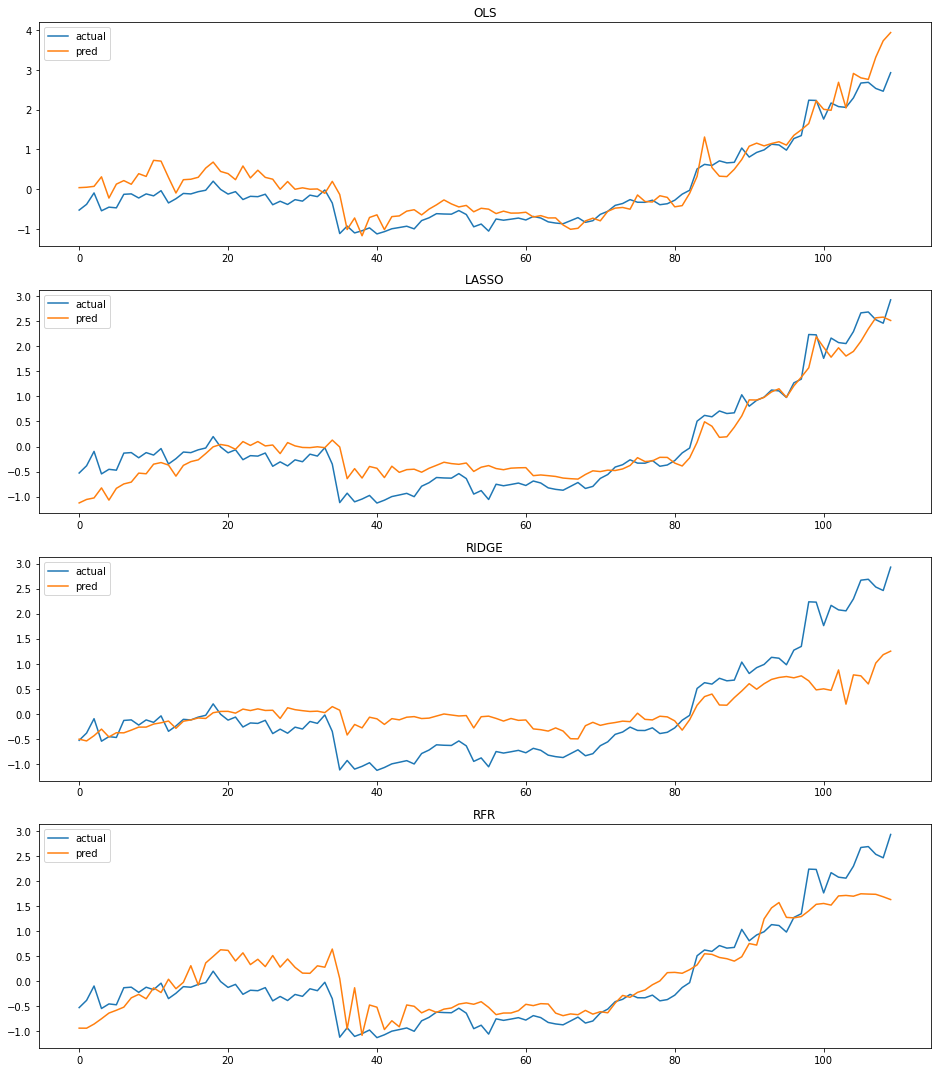

In [30]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(13, 15))
ax1.plot(y2_test)
ax1.plot(pred_ols2)
ax1.legend(["actual", "pred"])
ax1.set_title("OLS")
ax2.plot(y2_test)
ax2.plot(pred_lasso2)
ax2.legend(["actual", "pred"])
ax2.set_title("LASSO")
ax3.plot(y2_test)
ax3.plot(pred_ridge2)
ax3.legend(["actual", "pred"])
ax3.set_title("RIDGE")
ax4.plot(y2_test)
ax4.plot(pred_rfr2)
ax4.legend(["actual", "pred"])
ax4.set_title("RFR")
fig.tight_layout()

plt.show()

fig.savefig('ActualVsTest(Test2_subplot2).png')

## Long Short Term Memory (LSTM)

- Using "Hyperas" wrapper for hyperparameters

In [32]:
from __future__ import print_function
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def data():
    
    dataset = read_csv('data/train.csv', index_col='Date')
    
    X = dataset.drop(labels=['close_nextday', 'close'], axis=1)
    y = dataset['close_nextday']
    
    
    tss = TimeSeriesSplit(n_splits=3)  # n_splits = 3-1...2 splits - 75% train, 25% test

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    # Reshape y train, test to match X train, test

    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)
    
    
    ss = StandardScaler()

    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)
    y_train = ss.fit_transform(y_train)
    y_test = ss.fit_transform(y_test)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    y_train = y_train.reshape(y_train.shape[0], 1, 1)
    y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
    return X_train, y_train, X_test, y_test

def model(X_train, y_train, X_test, y_test):

    model = Sequential()
    model.add(LSTM(128))
    model.add(Activation({{choice(['relu', 'sigmoid', 'linear', 'softmax'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(1))

    model.compile(loss='mse',
                  optimizer={{choice(['rmsprop', 'adam', 'sgd', 'nadam'])}},
                  metrics=['mse'])

    result = model.fit(X_train,
                       y_train,
                       batch_size={{choice([12, 24, 64, 128])}},
                       epochs={{choice([100, 200, 300, 400, 500])}},
                       verbose=2,
                       validation_data=(X_test, y_test))
                       

    score, mse = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':
    trials = Trials()
    best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=10,
                                          trials=trials,
                                          notebook_name="LSTM")
    
    for trial in trials:
        print(trial)
    
    X_train, y_train, X_test, y_test = data()
    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_test, y_test))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from keras.preprocessing import sequence
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.layers.embeddings import Embedding
except:
    pass

try:
    from keras.layers.recurrent import LSTM
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from pandas import read_csv
except:
    pass

try:
    from sklearn.model_selection import TimeSeriesSplit
except:
    pass

try:
    from sklearn.preprocessing import Standard

Epoch 20/200                                                                                                           
28/28 - 0s - loss: 1.0475 - mse: 1.0475 - val_loss: 1.1480 - val_mse: 1.1480                                           

Epoch 21/200                                                                                                           
28/28 - 0s - loss: 1.1161 - mse: 1.1161 - val_loss: 0.9907 - val_mse: 0.9907                                           

Epoch 22/200                                                                                                           
28/28 - 0s - loss: 1.0992 - mse: 1.0992 - val_loss: 1.0096 - val_mse: 1.0096                                           

Epoch 23/200                                                                                                           
28/28 - 0s - loss: 1.1302 - mse: 1.1302 - val_loss: 1.0438 - val_mse: 1.0438                                           

Epoch 24/200                        

28/28 - 0s - loss: 1.0869 - mse: 1.0869 - val_loss: 1.0597 - val_mse: 1.0597                                           

Epoch 54/200                                                                                                           
28/28 - 0s - loss: 1.0552 - mse: 1.0552 - val_loss: 0.9919 - val_mse: 0.9919                                           

Epoch 55/200                                                                                                           
28/28 - 0s - loss: 1.1803 - mse: 1.1803 - val_loss: 1.2170 - val_mse: 1.2170                                           

Epoch 56/200                                                                                                           
28/28 - 0s - loss: 1.1216 - mse: 1.1216 - val_loss: 1.0010 - val_mse: 1.0010                                           

Epoch 57/200                                                                                                           
28/28 - 0s - loss: 1.0930 - mse: 1.0

Epoch 87/200                                                                                                           
28/28 - 0s - loss: 1.1554 - mse: 1.1554 - val_loss: 0.9915 - val_mse: 0.9915                                           

Epoch 88/200                                                                                                           
28/28 - 0s - loss: 1.0907 - mse: 1.0907 - val_loss: 0.9881 - val_mse: 0.9881                                           

Epoch 89/200                                                                                                           
28/28 - 0s - loss: 1.1263 - mse: 1.1263 - val_loss: 1.1167 - val_mse: 1.1167                                           

Epoch 90/200                                                                                                           
28/28 - 0s - loss: 1.1277 - mse: 1.1277 - val_loss: 1.0556 - val_mse: 1.0556                                           

Epoch 91/200                        

28/28 - 0s - loss: 1.1109 - mse: 1.1109 - val_loss: 0.9699 - val_mse: 0.9699                                           

Epoch 121/200                                                                                                          
28/28 - 0s - loss: 1.1398 - mse: 1.1398 - val_loss: 1.0225 - val_mse: 1.0225                                           

Epoch 122/200                                                                                                          
28/28 - 0s - loss: 1.1156 - mse: 1.1156 - val_loss: 0.9891 - val_mse: 0.9891                                           

Epoch 123/200                                                                                                          
28/28 - 0s - loss: 1.0821 - mse: 1.0821 - val_loss: 0.9963 - val_mse: 0.9963                                           

Epoch 124/200                                                                                                          
28/28 - 0s - loss: 1.1085 - mse: 1.1

Epoch 154/200                                                                                                          
28/28 - 0s - loss: 1.1294 - mse: 1.1294 - val_loss: 0.9940 - val_mse: 0.9940                                           

Epoch 155/200                                                                                                          
28/28 - 0s - loss: 1.1002 - mse: 1.1002 - val_loss: 0.9613 - val_mse: 0.9613                                           

Epoch 156/200                                                                                                          
28/28 - 0s - loss: 1.1186 - mse: 1.1186 - val_loss: 0.9583 - val_mse: 0.9583                                           

Epoch 157/200                                                                                                          
28/28 - 0s - loss: 1.0531 - mse: 1.0531 - val_loss: 1.1629 - val_mse: 1.1629                                           

Epoch 158/200                       

28/28 - 0s - loss: 1.0777 - mse: 1.0777 - val_loss: 0.9582 - val_mse: 0.9582                                           

Epoch 188/200                                                                                                          
28/28 - 0s - loss: 1.1287 - mse: 1.1287 - val_loss: 0.9600 - val_mse: 0.9600                                           

Epoch 189/200                                                                                                          
28/28 - 0s - loss: 1.1113 - mse: 1.1113 - val_loss: 1.0084 - val_mse: 1.0084                                           

Epoch 190/200                                                                                                          
28/28 - 0s - loss: 1.0877 - mse: 1.0877 - val_loss: 0.9712 - val_mse: 0.9712                                           

Epoch 191/200                                                                                                          
28/28 - 0s - loss: 1.0948 - mse: 1.0

Epoch 20/200                                                                                                           
28/28 - 0s - loss: 0.2777 - mse: 0.2777 - val_loss: 0.1599 - val_mse: 0.1599                                           

Epoch 21/200                                                                                                           
28/28 - 0s - loss: 0.2848 - mse: 0.2848 - val_loss: 0.1501 - val_mse: 0.1501                                           

Epoch 22/200                                                                                                           
28/28 - 0s - loss: 0.2773 - mse: 0.2773 - val_loss: 0.1542 - val_mse: 0.1542                                           

Epoch 23/200                                                                                                           
28/28 - 0s - loss: 0.2525 - mse: 0.2525 - val_loss: 0.1461 - val_mse: 0.1461                                           

Epoch 24/200                        

28/28 - 0s - loss: 0.2134 - mse: 0.2134 - val_loss: 0.1061 - val_mse: 0.1061                                           

Epoch 54/200                                                                                                           
28/28 - 0s - loss: 0.2193 - mse: 0.2193 - val_loss: 0.1021 - val_mse: 0.1021                                           

Epoch 55/200                                                                                                           
28/28 - 0s - loss: 0.2109 - mse: 0.2109 - val_loss: 0.1078 - val_mse: 0.1078                                           

Epoch 56/200                                                                                                           
28/28 - 0s - loss: 0.2209 - mse: 0.2209 - val_loss: 0.1079 - val_mse: 0.1079                                           

Epoch 57/200                                                                                                           
28/28 - 0s - loss: 0.2348 - mse: 0.2

Epoch 87/200                                                                                                           
28/28 - 0s - loss: 0.1979 - mse: 0.1979 - val_loss: 0.0957 - val_mse: 0.0957                                           

Epoch 88/200                                                                                                           
28/28 - 0s - loss: 0.2063 - mse: 0.2063 - val_loss: 0.0941 - val_mse: 0.0941                                           

Epoch 89/200                                                                                                           
28/28 - 0s - loss: 0.2127 - mse: 0.2127 - val_loss: 0.1005 - val_mse: 0.1005                                           

Epoch 90/200                                                                                                           
28/28 - 0s - loss: 0.2148 - mse: 0.2148 - val_loss: 0.0992 - val_mse: 0.0992                                           

Epoch 91/200                        

28/28 - 0s - loss: 0.2154 - mse: 0.2154 - val_loss: 0.0894 - val_mse: 0.0894                                           

Epoch 121/200                                                                                                          
28/28 - 0s - loss: 0.2183 - mse: 0.2183 - val_loss: 0.0942 - val_mse: 0.0942                                           

Epoch 122/200                                                                                                          
28/28 - 0s - loss: 0.2095 - mse: 0.2095 - val_loss: 0.0929 - val_mse: 0.0929                                           

Epoch 123/200                                                                                                          
28/28 - 0s - loss: 0.2101 - mse: 0.2101 - val_loss: 0.0926 - val_mse: 0.0926                                           

Epoch 124/200                                                                                                          
28/28 - 0s - loss: 0.1939 - mse: 0.1

Epoch 154/200                                                                                                          
28/28 - 0s - loss: 0.2162 - mse: 0.2162 - val_loss: 0.0840 - val_mse: 0.0840                                           

Epoch 155/200                                                                                                          
28/28 - 0s - loss: 0.1977 - mse: 0.1977 - val_loss: 0.0847 - val_mse: 0.0847                                           

Epoch 156/200                                                                                                          
28/28 - 0s - loss: 0.1891 - mse: 0.1891 - val_loss: 0.0845 - val_mse: 0.0845                                           

Epoch 157/200                                                                                                          
28/28 - 0s - loss: 0.2046 - mse: 0.2046 - val_loss: 0.0842 - val_mse: 0.0842                                           

Epoch 158/200                       

28/28 - 0s - loss: 0.2070 - mse: 0.2070 - val_loss: 0.0912 - val_mse: 0.0912                                           

Epoch 188/200                                                                                                          
28/28 - 0s - loss: 0.1932 - mse: 0.1932 - val_loss: 0.0933 - val_mse: 0.0933                                           

Epoch 189/200                                                                                                          
28/28 - 0s - loss: 0.1729 - mse: 0.1729 - val_loss: 0.0923 - val_mse: 0.0923                                           

Epoch 190/200                                                                                                          
28/28 - 0s - loss: 0.1973 - mse: 0.1973 - val_loss: 0.0928 - val_mse: 0.0928                                           

Epoch 191/200                                                                                                          
28/28 - 0s - loss: 0.1990 - mse: 0.1

Epoch 20/300                                                                                                           
6/6 - 0s - loss: 1.4492 - mse: 1.4492 - val_loss: 0.7804 - val_mse: 0.7804                                             

Epoch 21/300                                                                                                           
6/6 - 0s - loss: 1.5321 - mse: 1.5321 - val_loss: 0.7764 - val_mse: 0.7764                                             

Epoch 22/300                                                                                                           
6/6 - 0s - loss: 1.3825 - mse: 1.3825 - val_loss: 0.7704 - val_mse: 0.7704                                             

Epoch 23/300                                                                                                           
6/6 - 0s - loss: 1.3024 - mse: 1.3024 - val_loss: 0.7708 - val_mse: 0.7708                                             

Epoch 24/300                        

6/6 - 0s - loss: 0.9407 - mse: 0.9407 - val_loss: 0.6896 - val_mse: 0.6896                                             

Epoch 54/300                                                                                                           
6/6 - 0s - loss: 0.9913 - mse: 0.9913 - val_loss: 0.6879 - val_mse: 0.6879                                             

Epoch 55/300                                                                                                           
6/6 - 0s - loss: 0.8623 - mse: 0.8623 - val_loss: 0.6847 - val_mse: 0.6847                                             

Epoch 56/300                                                                                                           
6/6 - 0s - loss: 0.8222 - mse: 0.8222 - val_loss: 0.6827 - val_mse: 0.6827                                             

Epoch 57/300                                                                                                           
6/6 - 0s - loss: 0.9332 - mse: 0.933

Epoch 87/300                                                                                                           
6/6 - 0s - loss: 0.8155 - mse: 0.8155 - val_loss: 0.6321 - val_mse: 0.6321                                             

Epoch 88/300                                                                                                           
6/6 - 0s - loss: 0.7785 - mse: 0.7785 - val_loss: 0.6317 - val_mse: 0.6317                                             

Epoch 89/300                                                                                                           
6/6 - 0s - loss: 0.7286 - mse: 0.7286 - val_loss: 0.6293 - val_mse: 0.6293                                             

Epoch 90/300                                                                                                           
6/6 - 0s - loss: 0.7436 - mse: 0.7436 - val_loss: 0.6276 - val_mse: 0.6276                                             

Epoch 91/300                        

6/6 - 0s - loss: 0.7361 - mse: 0.7361 - val_loss: 0.5653 - val_mse: 0.5653                                             

Epoch 121/300                                                                                                          
6/6 - 0s - loss: 0.6765 - mse: 0.6765 - val_loss: 0.5620 - val_mse: 0.5620                                             

Epoch 122/300                                                                                                          
6/6 - 0s - loss: 0.7116 - mse: 0.7116 - val_loss: 0.5595 - val_mse: 0.5595                                             

Epoch 123/300                                                                                                          
6/6 - 0s - loss: 0.6957 - mse: 0.6957 - val_loss: 0.5581 - val_mse: 0.5581                                             

Epoch 124/300                                                                                                          
6/6 - 0s - loss: 0.6920 - mse: 0.692

Epoch 154/300                                                                                                          
6/6 - 0s - loss: 0.5938 - mse: 0.5938 - val_loss: 0.5051 - val_mse: 0.5051                                             

Epoch 155/300                                                                                                          
6/6 - 0s - loss: 0.6578 - mse: 0.6578 - val_loss: 0.5026 - val_mse: 0.5026                                             

Epoch 156/300                                                                                                          
6/6 - 0s - loss: 0.6612 - mse: 0.6612 - val_loss: 0.4999 - val_mse: 0.4999                                             

Epoch 157/300                                                                                                          
6/6 - 0s - loss: 0.6636 - mse: 0.6636 - val_loss: 0.4980 - val_mse: 0.4980                                             

Epoch 158/300                       

6/6 - 0s - loss: 0.6356 - mse: 0.6356 - val_loss: 0.4645 - val_mse: 0.4645                                             

Epoch 188/300                                                                                                          
6/6 - 0s - loss: 0.6331 - mse: 0.6331 - val_loss: 0.4639 - val_mse: 0.4639                                             

Epoch 189/300                                                                                                          
6/6 - 0s - loss: 0.5749 - mse: 0.5749 - val_loss: 0.4625 - val_mse: 0.4625                                             

Epoch 190/300                                                                                                          
6/6 - 0s - loss: 0.5867 - mse: 0.5867 - val_loss: 0.4596 - val_mse: 0.4596                                             

Epoch 191/300                                                                                                          
6/6 - 0s - loss: 0.6219 - mse: 0.621

Epoch 221/300                                                                                                          
6/6 - 0s - loss: 0.5263 - mse: 0.5263 - val_loss: 0.4352 - val_mse: 0.4352                                             

Epoch 222/300                                                                                                          
6/6 - 0s - loss: 0.5757 - mse: 0.5757 - val_loss: 0.4341 - val_mse: 0.4341                                             

Epoch 223/300                                                                                                          
6/6 - 0s - loss: 0.5760 - mse: 0.5760 - val_loss: 0.4334 - val_mse: 0.4334                                             

Epoch 224/300                                                                                                          
6/6 - 0s - loss: 0.6139 - mse: 0.6139 - val_loss: 0.4368 - val_mse: 0.4368                                             

Epoch 225/300                       

6/6 - 0s - loss: 0.5070 - mse: 0.5070 - val_loss: 0.4344 - val_mse: 0.4344                                             

Epoch 255/300                                                                                                          
6/6 - 0s - loss: 0.5936 - mse: 0.5936 - val_loss: 0.4238 - val_mse: 0.4238                                             

Epoch 256/300                                                                                                          
6/6 - 0s - loss: 0.5435 - mse: 0.5435 - val_loss: 0.4233 - val_mse: 0.4233                                             

Epoch 257/300                                                                                                          
6/6 - 0s - loss: 0.5427 - mse: 0.5427 - val_loss: 0.4219 - val_mse: 0.4219                                             

Epoch 258/300                                                                                                          
6/6 - 0s - loss: 0.6351 - mse: 0.635

Epoch 288/300                                                                                                          
6/6 - 0s - loss: 0.5479 - mse: 0.5479 - val_loss: 0.4181 - val_mse: 0.4181                                             

Epoch 289/300                                                                                                          
6/6 - 0s - loss: 0.5425 - mse: 0.5425 - val_loss: 0.4179 - val_mse: 0.4179                                             

Epoch 290/300                                                                                                          
6/6 - 0s - loss: 0.5450 - mse: 0.5450 - val_loss: 0.4206 - val_mse: 0.4206                                             

Epoch 291/300                                                                                                          
6/6 - 0s - loss: 0.5522 - mse: 0.5522 - val_loss: 0.4201 - val_mse: 0.4201                                             

Epoch 292/300                       

Epoch 21/200                                                                                                           
6/6 - 0s - loss: 0.3271 - mse: 0.3271 - val_loss: 0.2753 - val_mse: 0.2753                                             

Epoch 22/200                                                                                                           
6/6 - 0s - loss: 0.3205 - mse: 0.3205 - val_loss: 0.2729 - val_mse: 0.2729                                             

Epoch 23/200                                                                                                           
6/6 - 0s - loss: 0.2957 - mse: 0.2957 - val_loss: 0.2680 - val_mse: 0.2680                                             

Epoch 24/200                                                                                                           
6/6 - 0s - loss: 0.3259 - mse: 0.3259 - val_loss: 0.2628 - val_mse: 0.2628                                             

Epoch 25/200                        

6/6 - 0s - loss: 0.2634 - mse: 0.2634 - val_loss: 0.1734 - val_mse: 0.1734                                             

Epoch 55/200                                                                                                           
6/6 - 0s - loss: 0.2388 - mse: 0.2388 - val_loss: 0.1708 - val_mse: 0.1708                                             

Epoch 56/200                                                                                                           
6/6 - 0s - loss: 0.2678 - mse: 0.2678 - val_loss: 0.1706 - val_mse: 0.1706                                             

Epoch 57/200                                                                                                           
6/6 - 0s - loss: 0.2544 - mse: 0.2544 - val_loss: 0.1677 - val_mse: 0.1677                                             

Epoch 58/200                                                                                                           
6/6 - 0s - loss: 0.2436 - mse: 0.243

Epoch 88/200                                                                                                           
6/6 - 0s - loss: 0.2218 - mse: 0.2218 - val_loss: 0.1211 - val_mse: 0.1211                                             

Epoch 89/200                                                                                                           
6/6 - 0s - loss: 0.2259 - mse: 0.2259 - val_loss: 0.1212 - val_mse: 0.1212                                             

Epoch 90/200                                                                                                           
6/6 - 0s - loss: 0.2279 - mse: 0.2279 - val_loss: 0.1219 - val_mse: 0.1219                                             

Epoch 91/200                                                                                                           
6/6 - 0s - loss: 0.2144 - mse: 0.2144 - val_loss: 0.1212 - val_mse: 0.1212                                             

Epoch 92/200                        

6/6 - 0s - loss: 0.2017 - mse: 0.2017 - val_loss: 0.0963 - val_mse: 0.0963                                             

Epoch 122/200                                                                                                          
6/6 - 0s - loss: 0.2032 - mse: 0.2032 - val_loss: 0.0968 - val_mse: 0.0968                                             

Epoch 123/200                                                                                                          
6/6 - 0s - loss: 0.2065 - mse: 0.2065 - val_loss: 0.0948 - val_mse: 0.0948                                             

Epoch 124/200                                                                                                          
6/6 - 0s - loss: 0.1961 - mse: 0.1961 - val_loss: 0.0930 - val_mse: 0.0930                                             

Epoch 125/200                                                                                                          
6/6 - 0s - loss: 0.2180 - mse: 0.218

Epoch 155/200                                                                                                          
6/6 - 0s - loss: 0.1905 - mse: 0.1905 - val_loss: 0.0818 - val_mse: 0.0818                                             

Epoch 156/200                                                                                                          
6/6 - 0s - loss: 0.1950 - mse: 0.1950 - val_loss: 0.0828 - val_mse: 0.0828                                             

Epoch 157/200                                                                                                          
6/6 - 0s - loss: 0.1953 - mse: 0.1953 - val_loss: 0.0819 - val_mse: 0.0819                                             

Epoch 158/200                                                                                                          
6/6 - 0s - loss: 0.1853 - mse: 0.1853 - val_loss: 0.0808 - val_mse: 0.0808                                             

Epoch 159/200                       

6/6 - 0s - loss: 0.1981 - mse: 0.1981 - val_loss: 0.0765 - val_mse: 0.0765                                             

Epoch 189/200                                                                                                          
6/6 - 0s - loss: 0.2040 - mse: 0.2040 - val_loss: 0.0786 - val_mse: 0.0786                                             

Epoch 190/200                                                                                                          
6/6 - 0s - loss: 0.1872 - mse: 0.1872 - val_loss: 0.0780 - val_mse: 0.0780                                             

Epoch 191/200                                                                                                          
6/6 - 0s - loss: 0.1842 - mse: 0.1842 - val_loss: 0.0770 - val_mse: 0.0770                                             

Epoch 192/200                                                                                                          
6/6 - 0s - loss: 0.1980 - mse: 0.198

Epoch 21/500                                                                                                           
3/3 - 0s - loss: 0.9903 - mse: 0.9903 - val_loss: 0.9942 - val_mse: 0.9942                                             

Epoch 22/500                                                                                                           
3/3 - 0s - loss: 0.9917 - mse: 0.9917 - val_loss: 0.9938 - val_mse: 0.9938                                             

Epoch 23/500                                                                                                           
3/3 - 0s - loss: 0.9905 - mse: 0.9905 - val_loss: 0.9934 - val_mse: 0.9934                                             

Epoch 24/500                                                                                                           
3/3 - 0s - loss: 0.9898 - mse: 0.9898 - val_loss: 0.9929 - val_mse: 0.9929                                             

Epoch 25/500                        

3/3 - 0s - loss: 0.9576 - mse: 0.9576 - val_loss: 0.9690 - val_mse: 0.9690                                             

Epoch 55/500                                                                                                           
3/3 - 0s - loss: 0.9559 - mse: 0.9559 - val_loss: 0.9678 - val_mse: 0.9678                                             

Epoch 56/500                                                                                                           
3/3 - 0s - loss: 0.9536 - mse: 0.9536 - val_loss: 0.9666 - val_mse: 0.9666                                             

Epoch 57/500                                                                                                           
3/3 - 0s - loss: 0.9526 - mse: 0.9526 - val_loss: 0.9653 - val_mse: 0.9653                                             

Epoch 58/500                                                                                                           
3/3 - 0s - loss: 0.9526 - mse: 0.952

Epoch 88/500                                                                                                           
3/3 - 0s - loss: 0.9053 - mse: 0.9053 - val_loss: 0.9190 - val_mse: 0.9190                                             

Epoch 89/500                                                                                                           
3/3 - 0s - loss: 0.9018 - mse: 0.9018 - val_loss: 0.9174 - val_mse: 0.9174                                             

Epoch 90/500                                                                                                           
3/3 - 0s - loss: 0.8976 - mse: 0.8976 - val_loss: 0.9157 - val_mse: 0.9157                                             

Epoch 91/500                                                                                                           
3/3 - 0s - loss: 0.8944 - mse: 0.8944 - val_loss: 0.9140 - val_mse: 0.9140                                             

Epoch 92/500                        

3/3 - 0s - loss: 0.8447 - mse: 0.8447 - val_loss: 0.8632 - val_mse: 0.8632                                             

Epoch 122/500                                                                                                          
3/3 - 0s - loss: 0.8410 - mse: 0.8410 - val_loss: 0.8614 - val_mse: 0.8614                                             

Epoch 123/500                                                                                                          
3/3 - 0s - loss: 0.8379 - mse: 0.8379 - val_loss: 0.8597 - val_mse: 0.8597                                             

Epoch 124/500                                                                                                          
3/3 - 0s - loss: 0.8335 - mse: 0.8335 - val_loss: 0.8579 - val_mse: 0.8579                                             

Epoch 125/500                                                                                                          
3/3 - 0s - loss: 0.8305 - mse: 0.830

Epoch 155/500                                                                                                          
3/3 - 0s - loss: 0.7756 - mse: 0.7756 - val_loss: 0.8047 - val_mse: 0.8047                                             

Epoch 156/500                                                                                                          
3/3 - 0s - loss: 0.7751 - mse: 0.7751 - val_loss: 0.8030 - val_mse: 0.8030                                             

Epoch 157/500                                                                                                          
3/3 - 0s - loss: 0.7746 - mse: 0.7746 - val_loss: 0.8012 - val_mse: 0.8012                                             

Epoch 158/500                                                                                                          
3/3 - 0s - loss: 0.7775 - mse: 0.7775 - val_loss: 0.7995 - val_mse: 0.7995                                             

Epoch 159/500                       

3/3 - 0s - loss: 0.7145 - mse: 0.7145 - val_loss: 0.7474 - val_mse: 0.7474                                             

Epoch 189/500                                                                                                          
3/3 - 0s - loss: 0.7182 - mse: 0.7182 - val_loss: 0.7457 - val_mse: 0.7457                                             

Epoch 190/500                                                                                                          
3/3 - 0s - loss: 0.7082 - mse: 0.7082 - val_loss: 0.7440 - val_mse: 0.7440                                             

Epoch 191/500                                                                                                          
3/3 - 0s - loss: 0.7073 - mse: 0.7073 - val_loss: 0.7422 - val_mse: 0.7422                                             

Epoch 192/500                                                                                                          
3/3 - 0s - loss: 0.7086 - mse: 0.708

Epoch 222/500                                                                                                          
3/3 - 0s - loss: 0.6526 - mse: 0.6526 - val_loss: 0.6888 - val_mse: 0.6888                                             

Epoch 223/500                                                                                                          
3/3 - 0s - loss: 0.6555 - mse: 0.6555 - val_loss: 0.6870 - val_mse: 0.6870                                             

Epoch 224/500                                                                                                          
3/3 - 0s - loss: 0.6510 - mse: 0.6510 - val_loss: 0.6853 - val_mse: 0.6853                                             

Epoch 225/500                                                                                                          
3/3 - 0s - loss: 0.6409 - mse: 0.6409 - val_loss: 0.6835 - val_mse: 0.6835                                             

Epoch 226/500                       

3/3 - 0s - loss: 0.5964 - mse: 0.5964 - val_loss: 0.6322 - val_mse: 0.6322                                             

Epoch 256/500                                                                                                          
3/3 - 0s - loss: 0.5942 - mse: 0.5942 - val_loss: 0.6306 - val_mse: 0.6306                                             

Epoch 257/500                                                                                                          
3/3 - 0s - loss: 0.5914 - mse: 0.5914 - val_loss: 0.6290 - val_mse: 0.6290                                             

Epoch 258/500                                                                                                          
3/3 - 0s - loss: 0.5942 - mse: 0.5942 - val_loss: 0.6273 - val_mse: 0.6273                                             

Epoch 259/500                                                                                                          
3/3 - 0s - loss: 0.5916 - mse: 0.591

Epoch 289/500                                                                                                          
3/3 - 0s - loss: 0.5421 - mse: 0.5421 - val_loss: 0.5805 - val_mse: 0.5805                                             

Epoch 290/500                                                                                                          
3/3 - 0s - loss: 0.5417 - mse: 0.5417 - val_loss: 0.5791 - val_mse: 0.5791                                             

Epoch 291/500                                                                                                          
3/3 - 0s - loss: 0.5375 - mse: 0.5375 - val_loss: 0.5778 - val_mse: 0.5778                                             

Epoch 292/500                                                                                                          
3/3 - 0s - loss: 0.5403 - mse: 0.5403 - val_loss: 0.5764 - val_mse: 0.5764                                             

Epoch 293/500                       

3/3 - 0s - loss: 0.4883 - mse: 0.4883 - val_loss: 0.5381 - val_mse: 0.5381                                             

Epoch 323/500                                                                                                          
3/3 - 0s - loss: 0.4915 - mse: 0.4915 - val_loss: 0.5370 - val_mse: 0.5370                                             

Epoch 324/500                                                                                                          
3/3 - 0s - loss: 0.4927 - mse: 0.4927 - val_loss: 0.5360 - val_mse: 0.5360                                             

Epoch 325/500                                                                                                          
3/3 - 0s - loss: 0.4900 - mse: 0.4900 - val_loss: 0.5349 - val_mse: 0.5349                                             

Epoch 326/500                                                                                                          
3/3 - 0s - loss: 0.4918 - mse: 0.491

Epoch 356/500                                                                                                          
3/3 - 0s - loss: 0.4461 - mse: 0.4461 - val_loss: 0.5031 - val_mse: 0.5031                                             

Epoch 357/500                                                                                                          
3/3 - 0s - loss: 0.4491 - mse: 0.4491 - val_loss: 0.5022 - val_mse: 0.5022                                             

Epoch 358/500                                                                                                          
3/3 - 0s - loss: 0.4407 - mse: 0.4407 - val_loss: 0.5012 - val_mse: 0.5012                                             

Epoch 359/500                                                                                                          
3/3 - 0s - loss: 0.4481 - mse: 0.4481 - val_loss: 0.5003 - val_mse: 0.5003                                             

Epoch 360/500                       

3/3 - 0s - loss: 0.4068 - mse: 0.4068 - val_loss: 0.4758 - val_mse: 0.4758                                             

Epoch 390/500                                                                                                          
3/3 - 0s - loss: 0.4047 - mse: 0.4047 - val_loss: 0.4751 - val_mse: 0.4751                                             

Epoch 391/500                                                                                                          
3/3 - 0s - loss: 0.4142 - mse: 0.4142 - val_loss: 0.4744 - val_mse: 0.4744                                             

Epoch 392/500                                                                                                          
3/3 - 0s - loss: 0.4050 - mse: 0.4050 - val_loss: 0.4737 - val_mse: 0.4737                                             

Epoch 393/500                                                                                                          
3/3 - 0s - loss: 0.4080 - mse: 0.408

Epoch 423/500                                                                                                          
3/3 - 0s - loss: 0.3675 - mse: 0.3675 - val_loss: 0.4532 - val_mse: 0.4532                                             

Epoch 424/500                                                                                                          
3/3 - 0s - loss: 0.3725 - mse: 0.3725 - val_loss: 0.4527 - val_mse: 0.4527                                             

Epoch 425/500                                                                                                          
3/3 - 0s - loss: 0.3744 - mse: 0.3744 - val_loss: 0.4521 - val_mse: 0.4521                                             

Epoch 426/500                                                                                                          
3/3 - 0s - loss: 0.3741 - mse: 0.3741 - val_loss: 0.4515 - val_mse: 0.4515                                             

Epoch 427/500                       

3/3 - 0s - loss: 0.3520 - mse: 0.3520 - val_loss: 0.4352 - val_mse: 0.4352                                             

Epoch 457/500                                                                                                          
3/3 - 0s - loss: 0.3577 - mse: 0.3577 - val_loss: 0.4346 - val_mse: 0.4346                                             

Epoch 458/500                                                                                                          
3/3 - 0s - loss: 0.3530 - mse: 0.3530 - val_loss: 0.4341 - val_mse: 0.4341                                             

Epoch 459/500                                                                                                          
3/3 - 0s - loss: 0.3458 - mse: 0.3458 - val_loss: 0.4336 - val_mse: 0.4336                                             

Epoch 460/500                                                                                                          
3/3 - 0s - loss: 0.3442 - mse: 0.344

Epoch 490/500                                                                                                          
3/3 - 0s - loss: 0.3193 - mse: 0.3193 - val_loss: 0.4225 - val_mse: 0.4225                                             

Epoch 491/500                                                                                                          
3/3 - 0s - loss: 0.3295 - mse: 0.3295 - val_loss: 0.4220 - val_mse: 0.4220                                             

Epoch 492/500                                                                                                          
3/3 - 0s - loss: 0.3275 - mse: 0.3275 - val_loss: 0.4217 - val_mse: 0.4217                                             

Epoch 493/500                                                                                                          
3/3 - 0s - loss: 0.3266 - mse: 0.3266 - val_loss: 0.4214 - val_mse: 0.4214                                             

Epoch 494/500                       

Epoch 23/300                                                                                                           
6/6 - 0s - loss: 0.6927 - mse: 0.6927 - val_loss: 0.7857 - val_mse: 0.7857                                             

Epoch 24/300                                                                                                           
6/6 - 0s - loss: 0.6893 - mse: 0.6893 - val_loss: 0.7765 - val_mse: 0.7765                                             

Epoch 25/300                                                                                                           
6/6 - 0s - loss: 0.6711 - mse: 0.6711 - val_loss: 0.7651 - val_mse: 0.7651                                             

Epoch 26/300                                                                                                           
6/6 - 0s - loss: 0.6494 - mse: 0.6494 - val_loss: 0.7541 - val_mse: 0.7541                                             

Epoch 27/300                        

6/6 - 0s - loss: 0.4481 - mse: 0.4481 - val_loss: 0.5061 - val_mse: 0.5061                                             

Epoch 57/300                                                                                                           
6/6 - 0s - loss: 0.4392 - mse: 0.4392 - val_loss: 0.5004 - val_mse: 0.5004                                             

Epoch 58/300                                                                                                           
6/6 - 0s - loss: 0.4109 - mse: 0.4109 - val_loss: 0.4950 - val_mse: 0.4950                                             

Epoch 59/300                                                                                                           
6/6 - 0s - loss: 0.4150 - mse: 0.4150 - val_loss: 0.4898 - val_mse: 0.4898                                             

Epoch 60/300                                                                                                           
6/6 - 0s - loss: 0.4272 - mse: 0.427

Epoch 90/300                                                                                                           
6/6 - 0s - loss: 0.3481 - mse: 0.3481 - val_loss: 0.3725 - val_mse: 0.3725                                             

Epoch 91/300                                                                                                           
6/6 - 0s - loss: 0.3417 - mse: 0.3417 - val_loss: 0.3696 - val_mse: 0.3696                                             

Epoch 92/300                                                                                                           
6/6 - 0s - loss: 0.3473 - mse: 0.3473 - val_loss: 0.3675 - val_mse: 0.3675                                             

Epoch 93/300                                                                                                           
6/6 - 0s - loss: 0.3406 - mse: 0.3406 - val_loss: 0.3656 - val_mse: 0.3656                                             

Epoch 94/300                        

6/6 - 0s - loss: 0.3084 - mse: 0.3084 - val_loss: 0.3172 - val_mse: 0.3172                                             

Epoch 124/300                                                                                                          
6/6 - 0s - loss: 0.3236 - mse: 0.3236 - val_loss: 0.3158 - val_mse: 0.3158                                             

Epoch 125/300                                                                                                          
6/6 - 0s - loss: 0.2962 - mse: 0.2962 - val_loss: 0.3150 - val_mse: 0.3150                                             

Epoch 126/300                                                                                                          
6/6 - 0s - loss: 0.3170 - mse: 0.3170 - val_loss: 0.3141 - val_mse: 0.3141                                             

Epoch 127/300                                                                                                          
6/6 - 0s - loss: 0.3252 - mse: 0.325

Epoch 157/300                                                                                                          
6/6 - 0s - loss: 0.2936 - mse: 0.2936 - val_loss: 0.2907 - val_mse: 0.2907                                             

Epoch 158/300                                                                                                          
6/6 - 0s - loss: 0.2964 - mse: 0.2964 - val_loss: 0.2900 - val_mse: 0.2900                                             

Epoch 159/300                                                                                                          
6/6 - 0s - loss: 0.2925 - mse: 0.2925 - val_loss: 0.2893 - val_mse: 0.2893                                             

Epoch 160/300                                                                                                          
6/6 - 0s - loss: 0.2797 - mse: 0.2797 - val_loss: 0.2880 - val_mse: 0.2880                                             

Epoch 161/300                       

6/6 - 0s - loss: 0.2874 - mse: 0.2874 - val_loss: 0.2726 - val_mse: 0.2726                                             

Epoch 191/300                                                                                                          
6/6 - 0s - loss: 0.2821 - mse: 0.2821 - val_loss: 0.2727 - val_mse: 0.2727                                             

Epoch 192/300                                                                                                          
6/6 - 0s - loss: 0.2878 - mse: 0.2878 - val_loss: 0.2724 - val_mse: 0.2724                                             

Epoch 193/300                                                                                                          
6/6 - 0s - loss: 0.3016 - mse: 0.3016 - val_loss: 0.2714 - val_mse: 0.2714                                             

Epoch 194/300                                                                                                          
6/6 - 0s - loss: 0.2835 - mse: 0.283

Epoch 224/300                                                                                                          
6/6 - 0s - loss: 0.2752 - mse: 0.2752 - val_loss: 0.2581 - val_mse: 0.2581                                             

Epoch 225/300                                                                                                          
6/6 - 0s - loss: 0.2541 - mse: 0.2541 - val_loss: 0.2578 - val_mse: 0.2578                                             

Epoch 226/300                                                                                                          
6/6 - 0s - loss: 0.2799 - mse: 0.2799 - val_loss: 0.2570 - val_mse: 0.2570                                             

Epoch 227/300                                                                                                          
6/6 - 0s - loss: 0.2884 - mse: 0.2884 - val_loss: 0.2573 - val_mse: 0.2573                                             

Epoch 228/300                       

6/6 - 0s - loss: 0.2557 - mse: 0.2557 - val_loss: 0.2461 - val_mse: 0.2461                                             

Epoch 258/300                                                                                                          
6/6 - 0s - loss: 0.2755 - mse: 0.2755 - val_loss: 0.2463 - val_mse: 0.2463                                             

Epoch 259/300                                                                                                          
6/6 - 0s - loss: 0.2621 - mse: 0.2621 - val_loss: 0.2465 - val_mse: 0.2465                                             

Epoch 260/300                                                                                                          
6/6 - 0s - loss: 0.2698 - mse: 0.2698 - val_loss: 0.2464 - val_mse: 0.2464                                             

Epoch 261/300                                                                                                          
6/6 - 0s - loss: 0.2518 - mse: 0.251

Epoch 291/300                                                                                                          
6/6 - 0s - loss: 0.2479 - mse: 0.2479 - val_loss: 0.2402 - val_mse: 0.2402                                             

Epoch 292/300                                                                                                          
6/6 - 0s - loss: 0.2692 - mse: 0.2692 - val_loss: 0.2398 - val_mse: 0.2398                                             

Epoch 293/300                                                                                                          
6/6 - 0s - loss: 0.2673 - mse: 0.2673 - val_loss: 0.2398 - val_mse: 0.2398                                             

Epoch 294/300                                                                                                          
6/6 - 0s - loss: 0.2684 - mse: 0.2684 - val_loss: 0.2393 - val_mse: 0.2393                                             

Epoch 295/300                       

Epoch 24/400                                                                                                           
28/28 - 0s - loss: 0.1829 - mse: 0.1829 - val_loss: 0.0979 - val_mse: 0.0979                                           

Epoch 25/400                                                                                                           
28/28 - 0s - loss: 0.1823 - mse: 0.1823 - val_loss: 0.0918 - val_mse: 0.0918                                           

Epoch 26/400                                                                                                           
28/28 - 0s - loss: 0.1813 - mse: 0.1813 - val_loss: 0.0899 - val_mse: 0.0899                                           

Epoch 27/400                                                                                                           
28/28 - 0s - loss: 0.1758 - mse: 0.1758 - val_loss: 0.0862 - val_mse: 0.0862                                           

Epoch 28/400                        

28/28 - 0s - loss: 0.1597 - mse: 0.1597 - val_loss: 0.0771 - val_mse: 0.0771                                           

Epoch 58/400                                                                                                           
28/28 - 0s - loss: 0.1517 - mse: 0.1517 - val_loss: 0.0793 - val_mse: 0.0793                                           

Epoch 59/400                                                                                                           
28/28 - 0s - loss: 0.1622 - mse: 0.1622 - val_loss: 0.0776 - val_mse: 0.0776                                           

Epoch 60/400                                                                                                           
28/28 - 0s - loss: 0.1494 - mse: 0.1494 - val_loss: 0.0784 - val_mse: 0.0784                                           

Epoch 61/400                                                                                                           
28/28 - 0s - loss: 0.1513 - mse: 0.1

Epoch 91/400                                                                                                           
28/28 - 0s - loss: 0.1328 - mse: 0.1328 - val_loss: 0.1023 - val_mse: 0.1023                                           

Epoch 92/400                                                                                                           
28/28 - 0s - loss: 0.1423 - mse: 0.1423 - val_loss: 0.1006 - val_mse: 0.1006                                           

Epoch 93/400                                                                                                           
28/28 - 0s - loss: 0.1382 - mse: 0.1382 - val_loss: 0.0976 - val_mse: 0.0976                                           

Epoch 94/400                                                                                                           
28/28 - 0s - loss: 0.1319 - mse: 0.1319 - val_loss: 0.1010 - val_mse: 0.1010                                           

Epoch 95/400                        

28/28 - 0s - loss: 0.1359 - mse: 0.1359 - val_loss: 0.1313 - val_mse: 0.1313                                           

Epoch 125/400                                                                                                          
28/28 - 0s - loss: 0.1267 - mse: 0.1267 - val_loss: 0.1405 - val_mse: 0.1405                                           

Epoch 126/400                                                                                                          
28/28 - 0s - loss: 0.1339 - mse: 0.1339 - val_loss: 0.1401 - val_mse: 0.1401                                           

Epoch 127/400                                                                                                          
28/28 - 0s - loss: 0.1383 - mse: 0.1383 - val_loss: 0.1361 - val_mse: 0.1361                                           

Epoch 128/400                                                                                                          
28/28 - 0s - loss: 0.1296 - mse: 0.1

Epoch 158/400                                                                                                          
28/28 - 0s - loss: 0.1210 - mse: 0.1210 - val_loss: 0.1518 - val_mse: 0.1518                                           

Epoch 159/400                                                                                                          
28/28 - 0s - loss: 0.1251 - mse: 0.1251 - val_loss: 0.1612 - val_mse: 0.1612                                           

Epoch 160/400                                                                                                          
28/28 - 0s - loss: 0.1199 - mse: 0.1199 - val_loss: 0.1645 - val_mse: 0.1645                                           

Epoch 161/400                                                                                                          
28/28 - 0s - loss: 0.1323 - mse: 0.1323 - val_loss: 0.1580 - val_mse: 0.1580                                           

Epoch 162/400                       

28/28 - 0s - loss: 0.1201 - mse: 0.1201 - val_loss: 0.1813 - val_mse: 0.1813                                           

Epoch 192/400                                                                                                          
28/28 - 0s - loss: 0.1107 - mse: 0.1107 - val_loss: 0.1785 - val_mse: 0.1785                                           

Epoch 193/400                                                                                                          
28/28 - 0s - loss: 0.1234 - mse: 0.1234 - val_loss: 0.1792 - val_mse: 0.1792                                           

Epoch 194/400                                                                                                          
28/28 - 0s - loss: 0.1100 - mse: 0.1100 - val_loss: 0.1822 - val_mse: 0.1822                                           

Epoch 195/400                                                                                                          
28/28 - 0s - loss: 0.1191 - mse: 0.1

Epoch 225/400                                                                                                          
28/28 - 0s - loss: 0.1212 - mse: 0.1212 - val_loss: 0.2015 - val_mse: 0.2015                                           

Epoch 226/400                                                                                                          
28/28 - 0s - loss: 0.1094 - mse: 0.1094 - val_loss: 0.2127 - val_mse: 0.2127                                           

Epoch 227/400                                                                                                          
28/28 - 0s - loss: 0.1143 - mse: 0.1143 - val_loss: 0.1982 - val_mse: 0.1982                                           

Epoch 228/400                                                                                                          
28/28 - 0s - loss: 0.1176 - mse: 0.1176 - val_loss: 0.2105 - val_mse: 0.2105                                           

Epoch 229/400                       

28/28 - 0s - loss: 0.1123 - mse: 0.1123 - val_loss: 0.2299 - val_mse: 0.2299                                           

Epoch 259/400                                                                                                          
28/28 - 0s - loss: 0.1159 - mse: 0.1159 - val_loss: 0.2307 - val_mse: 0.2307                                           

Epoch 260/400                                                                                                          
28/28 - 0s - loss: 0.1131 - mse: 0.1131 - val_loss: 0.2202 - val_mse: 0.2202                                           

Epoch 261/400                                                                                                          
28/28 - 0s - loss: 0.1034 - mse: 0.1034 - val_loss: 0.2232 - val_mse: 0.2232                                           

Epoch 262/400                                                                                                          
28/28 - 0s - loss: 0.1144 - mse: 0.1

Epoch 292/400                                                                                                          
28/28 - 0s - loss: 0.1070 - mse: 0.1070 - val_loss: 0.2306 - val_mse: 0.2306                                           

Epoch 293/400                                                                                                          
28/28 - 0s - loss: 0.1042 - mse: 0.1042 - val_loss: 0.2268 - val_mse: 0.2268                                           

Epoch 294/400                                                                                                          
28/28 - 0s - loss: 0.1016 - mse: 0.1016 - val_loss: 0.2282 - val_mse: 0.2282                                           

Epoch 295/400                                                                                                          
28/28 - 0s - loss: 0.1136 - mse: 0.1136 - val_loss: 0.2275 - val_mse: 0.2275                                           

Epoch 296/400                       

28/28 - 0s - loss: 0.1054 - mse: 0.1054 - val_loss: 0.2450 - val_mse: 0.2450                                           

Epoch 326/400                                                                                                          
28/28 - 0s - loss: 0.0992 - mse: 0.0992 - val_loss: 0.2454 - val_mse: 0.2454                                           

Epoch 327/400                                                                                                          
28/28 - 0s - loss: 0.1096 - mse: 0.1096 - val_loss: 0.2354 - val_mse: 0.2354                                           

Epoch 328/400                                                                                                          
28/28 - 0s - loss: 0.1052 - mse: 0.1052 - val_loss: 0.2306 - val_mse: 0.2306                                           

Epoch 329/400                                                                                                          
28/28 - 0s - loss: 0.1062 - mse: 0.1

Epoch 359/400                                                                                                          
28/28 - 0s - loss: 0.0957 - mse: 0.0957 - val_loss: 0.2320 - val_mse: 0.2320                                           

Epoch 360/400                                                                                                          
28/28 - 0s - loss: 0.0993 - mse: 0.0993 - val_loss: 0.2381 - val_mse: 0.2381                                           

Epoch 361/400                                                                                                          
28/28 - 0s - loss: 0.1010 - mse: 0.1010 - val_loss: 0.2415 - val_mse: 0.2415                                           

Epoch 362/400                                                                                                          
28/28 - 0s - loss: 0.1015 - mse: 0.1015 - val_loss: 0.2386 - val_mse: 0.2386                                           

Epoch 363/400                       

28/28 - 0s - loss: 0.1027 - mse: 0.1027 - val_loss: 0.2361 - val_mse: 0.2361                                           

Epoch 393/400                                                                                                          
28/28 - 0s - loss: 0.0970 - mse: 0.0970 - val_loss: 0.2223 - val_mse: 0.2223                                           

Epoch 394/400                                                                                                          
28/28 - 0s - loss: 0.0943 - mse: 0.0943 - val_loss: 0.2528 - val_mse: 0.2528                                           

Epoch 395/400                                                                                                          
28/28 - 0s - loss: 0.1012 - mse: 0.1012 - val_loss: 0.2399 - val_mse: 0.2399                                           

Epoch 396/400                                                                                                          
28/28 - 0s - loss: 0.0948 - mse: 0.0

Epoch 25/400                                                                                                           
14/14 - 0s - loss: 0.4428 - mse: 0.4428 - val_loss: 0.4416 - val_mse: 0.4416                                           

Epoch 26/400                                                                                                           
14/14 - 0s - loss: 0.4312 - mse: 0.4312 - val_loss: 0.4275 - val_mse: 0.4275                                           

Epoch 27/400                                                                                                           
14/14 - 0s - loss: 0.4275 - mse: 0.4275 - val_loss: 0.4146 - val_mse: 0.4146                                           

Epoch 28/400                                                                                                           
14/14 - 0s - loss: 0.4047 - mse: 0.4047 - val_loss: 0.4025 - val_mse: 0.4025                                           

Epoch 29/400                        

14/14 - 0s - loss: 0.2786 - mse: 0.2786 - val_loss: 0.2567 - val_mse: 0.2567                                           

Epoch 59/400                                                                                                           
14/14 - 0s - loss: 0.2763 - mse: 0.2763 - val_loss: 0.2550 - val_mse: 0.2550                                           

Epoch 60/400                                                                                                           
14/14 - 0s - loss: 0.2799 - mse: 0.2799 - val_loss: 0.2537 - val_mse: 0.2537                                           

Epoch 61/400                                                                                                           
14/14 - 0s - loss: 0.2802 - mse: 0.2802 - val_loss: 0.2527 - val_mse: 0.2527                                           

Epoch 62/400                                                                                                           
14/14 - 0s - loss: 0.2679 - mse: 0.2

Epoch 92/400                                                                                                           
14/14 - 0s - loss: 0.2434 - mse: 0.2434 - val_loss: 0.2261 - val_mse: 0.2261                                           

Epoch 93/400                                                                                                           
14/14 - 0s - loss: 0.2415 - mse: 0.2415 - val_loss: 0.2253 - val_mse: 0.2253                                           

Epoch 94/400                                                                                                           
14/14 - 0s - loss: 0.2526 - mse: 0.2526 - val_loss: 0.2249 - val_mse: 0.2249                                           

Epoch 95/400                                                                                                           
14/14 - 0s - loss: 0.2433 - mse: 0.2433 - val_loss: 0.2244 - val_mse: 0.2244                                           

Epoch 96/400                        

14/14 - 0s - loss: 0.2217 - mse: 0.2217 - val_loss: 0.2114 - val_mse: 0.2114                                           

Epoch 126/400                                                                                                          
14/14 - 0s - loss: 0.2213 - mse: 0.2213 - val_loss: 0.2110 - val_mse: 0.2110                                           

Epoch 127/400                                                                                                          
14/14 - 0s - loss: 0.2215 - mse: 0.2215 - val_loss: 0.2110 - val_mse: 0.2110                                           

Epoch 128/400                                                                                                          
14/14 - 0s - loss: 0.2229 - mse: 0.2229 - val_loss: 0.2104 - val_mse: 0.2104                                           

Epoch 129/400                                                                                                          
14/14 - 0s - loss: 0.2158 - mse: 0.2

Epoch 159/400                                                                                                          
14/14 - 0s - loss: 0.2103 - mse: 0.2103 - val_loss: 0.2011 - val_mse: 0.2011                                           

Epoch 160/400                                                                                                          
14/14 - 0s - loss: 0.2114 - mse: 0.2114 - val_loss: 0.2005 - val_mse: 0.2005                                           

Epoch 161/400                                                                                                          
14/14 - 0s - loss: 0.2079 - mse: 0.2079 - val_loss: 0.2005 - val_mse: 0.2005                                           

Epoch 162/400                                                                                                          
14/14 - 0s - loss: 0.2153 - mse: 0.2153 - val_loss: 0.2007 - val_mse: 0.2007                                           

Epoch 163/400                       

14/14 - 0s - loss: 0.2121 - mse: 0.2121 - val_loss: 0.1924 - val_mse: 0.1924                                           

Epoch 193/400                                                                                                          
14/14 - 0s - loss: 0.1942 - mse: 0.1942 - val_loss: 0.1919 - val_mse: 0.1919                                           

Epoch 194/400                                                                                                          
14/14 - 0s - loss: 0.2041 - mse: 0.2041 - val_loss: 0.1915 - val_mse: 0.1915                                           

Epoch 195/400                                                                                                          
14/14 - 0s - loss: 0.1962 - mse: 0.1962 - val_loss: 0.1912 - val_mse: 0.1912                                           

Epoch 196/400                                                                                                          
14/14 - 0s - loss: 0.2004 - mse: 0.2

Epoch 226/400                                                                                                          
14/14 - 0s - loss: 0.1948 - mse: 0.1948 - val_loss: 0.1832 - val_mse: 0.1832                                           

Epoch 227/400                                                                                                          
14/14 - 0s - loss: 0.1989 - mse: 0.1989 - val_loss: 0.1829 - val_mse: 0.1829                                           

Epoch 228/400                                                                                                          
14/14 - 0s - loss: 0.1920 - mse: 0.1920 - val_loss: 0.1827 - val_mse: 0.1827                                           

Epoch 229/400                                                                                                          
14/14 - 0s - loss: 0.1976 - mse: 0.1976 - val_loss: 0.1829 - val_mse: 0.1829                                           

Epoch 230/400                       

14/14 - 0s - loss: 0.1856 - mse: 0.1856 - val_loss: 0.1762 - val_mse: 0.1762                                           

Epoch 260/400                                                                                                          
14/14 - 0s - loss: 0.1888 - mse: 0.1888 - val_loss: 0.1760 - val_mse: 0.1760                                           

Epoch 261/400                                                                                                          
14/14 - 0s - loss: 0.1884 - mse: 0.1884 - val_loss: 0.1756 - val_mse: 0.1756                                           

Epoch 262/400                                                                                                          
14/14 - 0s - loss: 0.1834 - mse: 0.1834 - val_loss: 0.1757 - val_mse: 0.1757                                           

Epoch 263/400                                                                                                          
14/14 - 0s - loss: 0.1921 - mse: 0.1

Epoch 293/400                                                                                                          
14/14 - 0s - loss: 0.1847 - mse: 0.1847 - val_loss: 0.1671 - val_mse: 0.1671                                           

Epoch 294/400                                                                                                          
14/14 - 0s - loss: 0.1831 - mse: 0.1831 - val_loss: 0.1668 - val_mse: 0.1668                                           

Epoch 295/400                                                                                                          
14/14 - 0s - loss: 0.1801 - mse: 0.1801 - val_loss: 0.1665 - val_mse: 0.1665                                           

Epoch 296/400                                                                                                          
14/14 - 0s - loss: 0.1776 - mse: 0.1776 - val_loss: 0.1663 - val_mse: 0.1663                                           

Epoch 297/400                       

14/14 - 0s - loss: 0.1794 - mse: 0.1794 - val_loss: 0.1583 - val_mse: 0.1583                                           

Epoch 327/400                                                                                                          
14/14 - 0s - loss: 0.1693 - mse: 0.1693 - val_loss: 0.1585 - val_mse: 0.1585                                           

Epoch 328/400                                                                                                          
14/14 - 0s - loss: 0.1797 - mse: 0.1797 - val_loss: 0.1582 - val_mse: 0.1582                                           

Epoch 329/400                                                                                                          
14/14 - 0s - loss: 0.1766 - mse: 0.1766 - val_loss: 0.1577 - val_mse: 0.1577                                           

Epoch 330/400                                                                                                          
14/14 - 0s - loss: 0.1816 - mse: 0.1

Epoch 360/400                                                                                                          
14/14 - 0s - loss: 0.1658 - mse: 0.1658 - val_loss: 0.1499 - val_mse: 0.1499                                           

Epoch 361/400                                                                                                          
14/14 - 0s - loss: 0.1676 - mse: 0.1676 - val_loss: 0.1494 - val_mse: 0.1494                                           

Epoch 362/400                                                                                                          
14/14 - 0s - loss: 0.1722 - mse: 0.1722 - val_loss: 0.1493 - val_mse: 0.1493                                           

Epoch 363/400                                                                                                          
14/14 - 0s - loss: 0.1698 - mse: 0.1698 - val_loss: 0.1495 - val_mse: 0.1495                                           

Epoch 364/400                       

14/14 - 0s - loss: 0.1625 - mse: 0.1625 - val_loss: 0.1426 - val_mse: 0.1426                                           

Epoch 394/400                                                                                                          
14/14 - 0s - loss: 0.1802 - mse: 0.1802 - val_loss: 0.1423 - val_mse: 0.1423                                           

Epoch 395/400                                                                                                          
14/14 - 0s - loss: 0.1661 - mse: 0.1661 - val_loss: 0.1420 - val_mse: 0.1420                                           

Epoch 396/400                                                                                                          
14/14 - 0s - loss: 0.1653 - mse: 0.1653 - val_loss: 0.1413 - val_mse: 0.1413                                           

Epoch 397/400                                                                                                          
14/14 - 0s - loss: 0.1752 - mse: 0.1

Epoch 26/300                                                                                                           
6/6 - 0s - loss: 0.9659 - mse: 0.9659 - val_loss: 0.9764 - val_mse: 0.9764                                             

Epoch 27/300                                                                                                           
6/6 - 0s - loss: 0.9638 - mse: 0.9638 - val_loss: 0.9752 - val_mse: 0.9752                                             

Epoch 28/300                                                                                                           
6/6 - 0s - loss: 0.9625 - mse: 0.9625 - val_loss: 0.9739 - val_mse: 0.9739                                             

Epoch 29/300                                                                                                           
6/6 - 0s - loss: 0.9602 - mse: 0.9602 - val_loss: 0.9724 - val_mse: 0.9724                                             

Epoch 30/300                        

6/6 - 0s - loss: 0.8945 - mse: 0.8945 - val_loss: 0.9132 - val_mse: 0.9132                                             

Epoch 60/300                                                                                                           
6/6 - 0s - loss: 0.8918 - mse: 0.8918 - val_loss: 0.9106 - val_mse: 0.9106                                             

Epoch 61/300                                                                                                           
6/6 - 0s - loss: 0.8892 - mse: 0.8892 - val_loss: 0.9085 - val_mse: 0.9085                                             

Epoch 62/300                                                                                                           
6/6 - 0s - loss: 0.8879 - mse: 0.8879 - val_loss: 0.9065 - val_mse: 0.9065                                             

Epoch 63/300                                                                                                           
6/6 - 0s - loss: 0.8850 - mse: 0.885

Epoch 93/300                                                                                                           
6/6 - 0s - loss: 0.8086 - mse: 0.8086 - val_loss: 0.8317 - val_mse: 0.8317                                             

Epoch 94/300                                                                                                           
6/6 - 0s - loss: 0.8042 - mse: 0.8042 - val_loss: 0.8291 - val_mse: 0.8291                                             

Epoch 95/300                                                                                                           
6/6 - 0s - loss: 0.8044 - mse: 0.8044 - val_loss: 0.8265 - val_mse: 0.8265                                             

Epoch 96/300                                                                                                           
6/6 - 0s - loss: 0.8032 - mse: 0.8032 - val_loss: 0.8241 - val_mse: 0.8241                                             

Epoch 97/300                        

6/6 - 0s - loss: 0.7176 - mse: 0.7176 - val_loss: 0.7462 - val_mse: 0.7462                                             

Epoch 127/300                                                                                                          
6/6 - 0s - loss: 0.7161 - mse: 0.7161 - val_loss: 0.7439 - val_mse: 0.7439                                             

Epoch 128/300                                                                                                          
6/6 - 0s - loss: 0.7111 - mse: 0.7111 - val_loss: 0.7415 - val_mse: 0.7415                                             

Epoch 129/300                                                                                                          
6/6 - 0s - loss: 0.7111 - mse: 0.7111 - val_loss: 0.7391 - val_mse: 0.7391                                             

Epoch 130/300                                                                                                          
6/6 - 0s - loss: 0.7075 - mse: 0.707

Epoch 160/300                                                                                                          
6/6 - 0s - loss: 0.6258 - mse: 0.6258 - val_loss: 0.6534 - val_mse: 0.6534                                             

Epoch 161/300                                                                                                          
6/6 - 0s - loss: 0.6231 - mse: 0.6231 - val_loss: 0.6510 - val_mse: 0.6510                                             

Epoch 162/300                                                                                                          
6/6 - 0s - loss: 0.6234 - mse: 0.6234 - val_loss: 0.6484 - val_mse: 0.6484                                             

Epoch 163/300                                                                                                          
6/6 - 0s - loss: 0.6173 - mse: 0.6173 - val_loss: 0.6457 - val_mse: 0.6457                                             

Epoch 164/300                       

6/6 - 0s - loss: 0.5398 - mse: 0.5398 - val_loss: 0.5697 - val_mse: 0.5697                                             

Epoch 194/300                                                                                                          
6/6 - 0s - loss: 0.5381 - mse: 0.5381 - val_loss: 0.5676 - val_mse: 0.5676                                             

Epoch 195/300                                                                                                          
6/6 - 0s - loss: 0.5354 - mse: 0.5354 - val_loss: 0.5653 - val_mse: 0.5653                                             

Epoch 196/300                                                                                                          
6/6 - 0s - loss: 0.5306 - mse: 0.5306 - val_loss: 0.5631 - val_mse: 0.5631                                             

Epoch 197/300                                                                                                          
6/6 - 0s - loss: 0.5281 - mse: 0.528

Epoch 227/300                                                                                                          
6/6 - 0s - loss: 0.4504 - mse: 0.4504 - val_loss: 0.4949 - val_mse: 0.4949                                             

Epoch 228/300                                                                                                          
6/6 - 0s - loss: 0.4495 - mse: 0.4495 - val_loss: 0.4924 - val_mse: 0.4924                                             

Epoch 229/300                                                                                                          
6/6 - 0s - loss: 0.4488 - mse: 0.4488 - val_loss: 0.4901 - val_mse: 0.4901                                             

Epoch 230/300                                                                                                          
6/6 - 0s - loss: 0.4454 - mse: 0.4454 - val_loss: 0.4884 - val_mse: 0.4884                                             

Epoch 231/300                       

6/6 - 0s - loss: 0.3873 - mse: 0.3873 - val_loss: 0.4383 - val_mse: 0.4383                                             

Epoch 261/300                                                                                                          
6/6 - 0s - loss: 0.3761 - mse: 0.3761 - val_loss: 0.4373 - val_mse: 0.4373                                             

Epoch 262/300                                                                                                          
6/6 - 0s - loss: 0.3793 - mse: 0.3793 - val_loss: 0.4365 - val_mse: 0.4365                                             

Epoch 263/300                                                                                                          
6/6 - 0s - loss: 0.3779 - mse: 0.3779 - val_loss: 0.4350 - val_mse: 0.4350                                             

Epoch 264/300                                                                                                          
6/6 - 0s - loss: 0.3734 - mse: 0.373

Epoch 294/300                                                                                                          
6/6 - 0s - loss: 0.3266 - mse: 0.3266 - val_loss: 0.4024 - val_mse: 0.4024                                             

Epoch 295/300                                                                                                          
6/6 - 0s - loss: 0.3264 - mse: 0.3264 - val_loss: 0.4014 - val_mse: 0.4014                                             

Epoch 296/300                                                                                                          
6/6 - 0s - loss: 0.3299 - mse: 0.3299 - val_loss: 0.4005 - val_mse: 0.4005                                             

Epoch 297/300                                                                                                          
6/6 - 0s - loss: 0.3268 - mse: 0.3268 - val_loss: 0.3994 - val_mse: 0.3994                                             

Epoch 298/300                       

Epoch 27/100                                                                                                           
3/3 - 0s - loss: 0.3032 - mse: 0.3032 - val_loss: 0.2906 - val_mse: 0.2906                                             

Epoch 28/100                                                                                                           
3/3 - 0s - loss: 0.2987 - mse: 0.2987 - val_loss: 0.2757 - val_mse: 0.2757                                             

Epoch 29/100                                                                                                           
3/3 - 0s - loss: 0.2913 - mse: 0.2913 - val_loss: 0.2624 - val_mse: 0.2624                                             

Epoch 30/100                                                                                                           
3/3 - 0s - loss: 0.2861 - mse: 0.2861 - val_loss: 0.2517 - val_mse: 0.2517                                             

Epoch 31/100                        

3/3 - 0s - loss: 0.2191 - mse: 0.2191 - val_loss: 0.1844 - val_mse: 0.1844                                             

Epoch 61/100                                                                                                           
3/3 - 0s - loss: 0.2232 - mse: 0.2232 - val_loss: 0.1836 - val_mse: 0.1836                                             

Epoch 62/100                                                                                                           
3/3 - 0s - loss: 0.2245 - mse: 0.2245 - val_loss: 0.1828 - val_mse: 0.1828                                             

Epoch 63/100                                                                                                           
3/3 - 0s - loss: 0.2100 - mse: 0.2100 - val_loss: 0.1823 - val_mse: 0.1823                                             

Epoch 64/100                                                                                                           
3/3 - 0s - loss: 0.2152 - mse: 0.215

Epoch 94/100                                                                                                           
3/3 - 0s - loss: 0.1717 - mse: 0.1717 - val_loss: 0.1556 - val_mse: 0.1556                                             

Epoch 95/100                                                                                                           
3/3 - 0s - loss: 0.1711 - mse: 0.1711 - val_loss: 0.1547 - val_mse: 0.1547                                             

Epoch 96/100                                                                                                           
3/3 - 0s - loss: 0.1749 - mse: 0.1749 - val_loss: 0.1537 - val_mse: 0.1537                                             

Epoch 97/100                                                                                                           
3/3 - 0s - loss: 0.1763 - mse: 0.1763 - val_loss: 0.1528 - val_mse: 0.1528                                             

Epoch 98/100                        

{'state': 2, 'tid': 9, 'spec': None, 'result': {'loss': 0.15056994557380676, 'status': 'ok', 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001330D6097C0>}, 'misc': {'tid': 9, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'Activation': [9], 'Dropout': [9], 'batch_size': [9], 'epochs': [9], 'optimizer': [9]}, 'vals': {'Activation': [0], 'Dropout': [0.20946774700477522], 'batch_size': [3], 'epochs': [0], 'optimizer': [1]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2021, 1, 15, 21, 29, 5, 888000), 'refresh_time': datetime.datetime(2021, 1, 15, 21, 29, 16, 753000)}
Evalutation of best performing model:
4/4 [==============================] - ETA: 0s - loss: 0.0862 - mse: 0.086 - 0s 3ms/step - loss: 0.0782 - mse: 0.0782
[0.07821875810623169, 0.07821875810623169]
Best performing model chosen hyper-parameters:
{'Activation': 2, 'Dropout': 0.7646166765488501, 'batch_size': 2, 'epochs': 1, 'optimizer'